# Index
- Attention Block
- MultiHeadAttention
- Encoder Layer
- Pytorch Official Implement

# 1. Attention Block
- Attention Head 개수(h)만큼 쌓여서 동작

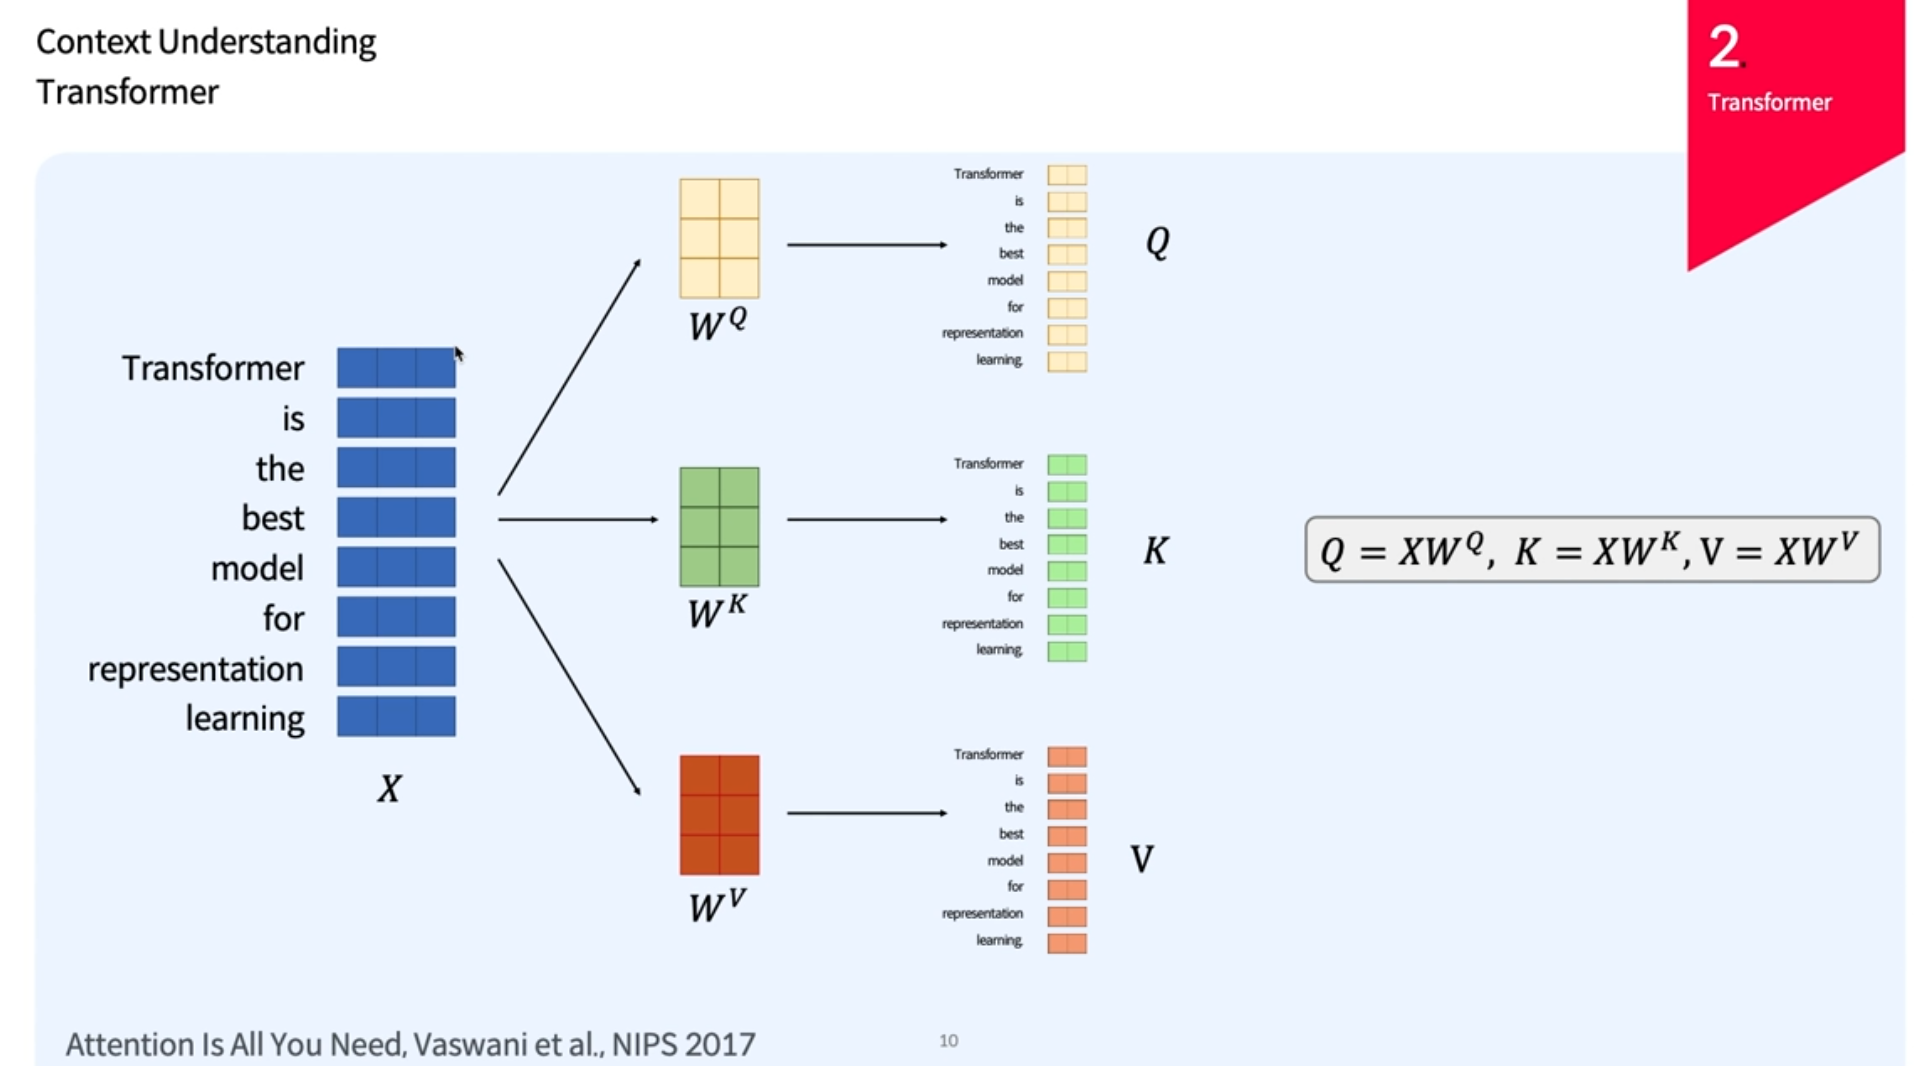

In [1]:
import torch

print(torch.__version__)

1.12.1+cu116


In [2]:
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
# Input Vector (위 이미지의 8개 단어에 대해 Vector화한 상태 가정)
X = torch.Tensor(torch.randn(8,3)).to(device)
X

tensor([[ 0.2434, -0.3696,  0.0857],
        [-0.1117, -0.0442,  0.6278],
        [ 1.2030, -0.2293,  1.7685],
        [-0.8793, -0.1287,  1.2788],
        [-0.3138, -0.3655,  0.2315],
        [ 0.6743, -1.2201,  2.0532],
        [-1.6710, -1.5032, -0.6154],
        [ 1.3665,  0.6922,  0.2201]], device='cuda:0')

In [4]:
# Query, Key, Value
W_Q = torch.nn.Parameter(torch.Tensor(torch.randn(3,2)).to(device))
W_K = torch.nn.Parameter(torch.Tensor(torch.randn(3,2)).to(device))
W_V = torch.nn.Parameter(torch.Tensor(torch.randn(3,2)).to(device))

W_Q

Parameter containing:
tensor([[ 0.4904, -1.2555],
        [-1.5358, -0.6225],
        [-1.0437, -0.7798]], device='cuda:0', requires_grad=True)

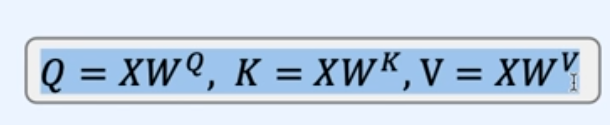

In [6]:
# Query, Key, Value Matrix
## 다양한 Matmul 연산 방법
Q = torch.matmul(X, W_Q)
Q = X.matmul(W_Q)
K = torch.mm(X, W_K)
V = X @ W_V

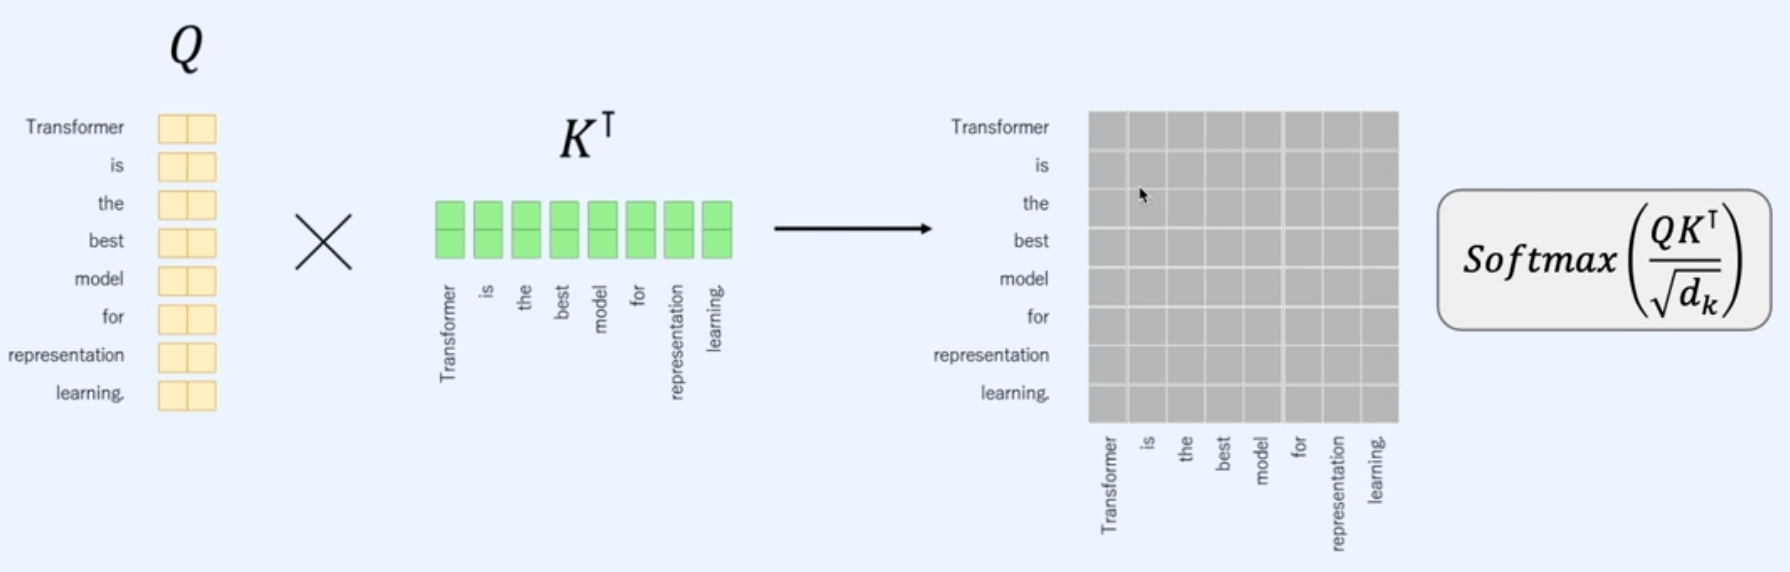

In [8]:
# Query-Key Matching을 통해 Attention Score(상호 관련성)의 초안이 되는 값을 뽑아줘야 한다

attention_score = Q @ K.T
attention_score

tensor([[ 1.6241e-01, -1.5997e-01,  8.8894e-01, -9.1186e-01, -3.4648e-01,
          2.6658e-01, -1.6275e+00,  1.2872e+00],
        [ 1.2570e-01, -2.2262e-01, -1.1435e+00, -1.7249e-01,  2.7052e-01,
         -3.7303e-01,  2.0028e+00, -1.1246e+00],
        [ 1.6273e+00, -2.2193e+00, -2.5177e+00, -5.8104e+00, -1.1141e-01,
         -9.4290e-01,  4.0439e+00, -3.3190e-01],
        [-3.0825e-01,  2.6479e-01, -2.4069e+00,  1.9403e+00,  8.6930e-01,
         -7.3362e-01,  4.3709e+00, -3.2765e+00],
        [-2.5871e-01,  3.5480e-01,  4.3700e-01,  9.1303e-01,  6.9075e-03,
          1.6152e-01, -7.0833e-01,  9.5302e-02],
        [ 1.0750e+00, -1.4071e+00, -5.7135e-01, -4.1561e+00, -3.9471e-01,
         -2.7749e-01,  7.2653e-01,  1.0450e+00],
        [-1.9634e+00,  2.7708e+00,  4.7637e+00,  6.5078e+00, -3.7325e-01,
          1.6836e+00, -7.9536e+00,  2.3991e+00],
        [ 1.3904e+00, -1.8828e+00, -1.9032e+00, -5.0367e+00, -1.6813e-01,
         -7.2719e-01,  3.0135e+00,  3.5778e-03]], device='cuda:0'

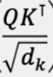

In [10]:
# Scaling Factor로 나눠줘야 한다 - feature dimension

d_k = K.shape[1]
print(f"Feature Dimension : {d_k}")

attention_score /= d_k**0.5
attention_score

Feature Dimension : 2


tensor([[ 1.1484e-01, -1.1311e-01,  6.2858e-01, -6.4478e-01, -2.4500e-01,
          1.8850e-01, -1.1508e+00,  9.1020e-01],
        [ 8.8881e-02, -1.5742e-01, -8.0856e-01, -1.2197e-01,  1.9129e-01,
         -2.6377e-01,  1.4162e+00, -7.9519e-01],
        [ 1.1507e+00, -1.5693e+00, -1.7803e+00, -4.1086e+00, -7.8778e-02,
         -6.6673e-01,  2.8595e+00, -2.3469e-01],
        [-2.1797e-01,  1.8723e-01, -1.7019e+00,  1.3720e+00,  6.1469e-01,
         -5.1875e-01,  3.0907e+00, -2.3169e+00],
        [-1.8294e-01,  2.5088e-01,  3.0900e-01,  6.4561e-01,  4.8843e-03,
          1.1421e-01, -5.0086e-01,  6.7388e-02],
        [ 7.6012e-01, -9.9497e-01, -4.0400e-01, -2.9388e+00, -2.7911e-01,
         -1.9622e-01,  5.1373e-01,  7.3894e-01],
        [-1.3883e+00,  1.9592e+00,  3.3684e+00,  4.6017e+00, -2.6392e-01,
          1.1905e+00, -5.6240e+00,  1.6964e+00],
        [ 9.8318e-01, -1.3314e+00, -1.3458e+00, -3.5615e+00, -1.1888e-01,
         -5.1420e-01,  2.1308e+00,  2.5299e-03]], device='cuda:0'

In [18]:
# 다만 해당 공식대로 진행한다고 해서 이렇게 진행할 경우, Q-K Matching 연산 -> Scaling Factor 단계로 넘어가는데
# 비효율적이기 때문에 이를 Q에 대해 먼저 계산함으로써 Scaling Factor 연산에 있어 64번이 아닌 16번만 하게 되는 효과

attention_score = (Q/(K.shape[1]**0.5)) @ K.T
attention_score

tensor([[ 1.1484e-01, -1.1311e-01,  6.2858e-01, -6.4478e-01, -2.4500e-01,
          1.8850e-01, -1.1508e+00,  9.1020e-01],
        [ 8.8881e-02, -1.5742e-01, -8.0856e-01, -1.2197e-01,  1.9129e-01,
         -2.6377e-01,  1.4162e+00, -7.9519e-01],
        [ 1.1507e+00, -1.5693e+00, -1.7803e+00, -4.1086e+00, -7.8778e-02,
         -6.6673e-01,  2.8595e+00, -2.3469e-01],
        [-2.1797e-01,  1.8723e-01, -1.7019e+00,  1.3720e+00,  6.1469e-01,
         -5.1875e-01,  3.0907e+00, -2.3169e+00],
        [-1.8294e-01,  2.5088e-01,  3.0900e-01,  6.4561e-01,  4.8843e-03,
          1.1421e-01, -5.0086e-01,  6.7388e-02],
        [ 7.6012e-01, -9.9497e-01, -4.0400e-01, -2.9388e+00, -2.7911e-01,
         -1.9622e-01,  5.1373e-01,  7.3894e-01],
        [-1.3883e+00,  1.9592e+00,  3.3684e+00,  4.6017e+00, -2.6392e-01,
          1.1905e+00, -5.6240e+00,  1.6964e+00],
        [ 9.8318e-01, -1.3314e+00, -1.3458e+00, -3.5615e+00, -1.1888e-01,
         -5.1420e-01,  2.1308e+00,  2.5298e-03]], device='cuda:0'

In [19]:
# 각 Score를 Scaling 

attention_score = torch.softmax(attention_score, dim=1)
attention_score

tensor([[1.2185e-01, 9.7009e-02, 2.0367e-01, 5.7005e-02, 8.5023e-02, 1.3116e-01,
         3.4368e-02, 2.6992e-01],
        [1.1119e-01, 8.6914e-02, 4.5321e-02, 9.0050e-02, 1.2318e-01, 7.8145e-02,
         4.1928e-01, 4.5931e-02],
        [1.3602e-01, 8.9607e-03, 7.2561e-03, 7.0720e-04, 3.9779e-02, 2.2096e-02,
         7.5114e-01, 3.4037e-02],
        [2.6219e-02, 3.9318e-02, 5.9449e-03, 1.2857e-01, 6.0289e-02, 1.9409e-02,
         7.1704e-01, 3.2143e-03],
        [9.0634e-02, 1.3986e-01, 1.4823e-01, 2.0755e-01, 1.0936e-01, 1.2200e-01,
         6.5951e-02, 1.1641e-01],
        [2.4947e-01, 4.3131e-02, 7.7883e-02, 6.1745e-03, 8.8244e-02, 9.5870e-02,
         1.9499e-01, 2.4424e-01],
        [1.7141e-03, 4.8738e-02, 1.9947e-01, 6.8470e-01, 5.2768e-03, 2.2595e-02,
         2.4803e-05, 3.7475e-02],
        [1.8908e-01, 1.8684e-02, 1.8417e-02, 2.0088e-03, 6.2811e-02, 4.2301e-02,
         5.9577e-01, 7.0920e-02]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [20]:
attention_score.sum(dim=0)

tensor([0.9262, 0.4826, 0.7062, 1.1768, 0.5740, 0.5336, 2.7786, 0.8222],
       device='cuda:0', grad_fn=<SumBackward1>)

In [21]:
attention_score.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<SumBackward1>)

### 최종적으로 Attention Score를 다시 Value에 곱해준다
- 이를 통해 위 그림 예시 중 각 단어의 벡터를 구현하기 위해 다른 단어의 벡터 몇 개가 필요한지를 연산하는 식

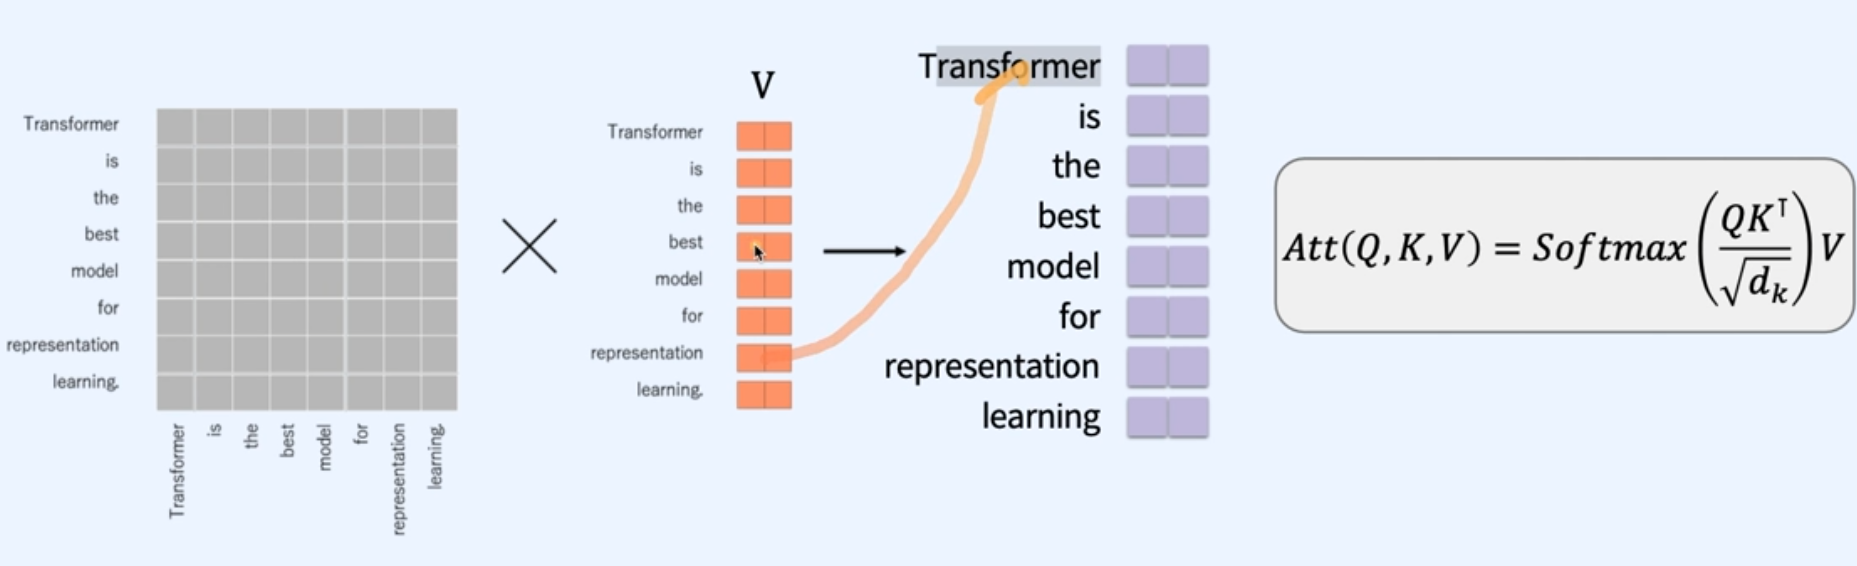

In [23]:
Z = attention_score @ V
print(Z.shape)

torch.Size([8, 2])


# 2. MultiHeadAttention 

In [40]:
# Class 자체에 종속된 변수가 없기 때문에 메서드 or 클래스 상관없음

import torch

def multi_head_attention(Q, K, V) :
        # Define : batch size, multi-head(h), max length, hidden dimension
        num_batch, num_head, num_token_length, att_dim = K.shape # 기존 Key에 배치 사이즈와 헤드 개수가 붙은 형태
        
        # 연산량 줄이기 위해 사전 계산
        Q /= (att_dim**0.5)
        
        # Attention Score 계산
        attention_score = Q @ K.permute(0,1,3,2) # .T를 통한 차원변환은 2차원에서만 작동하기 때문에 Tensor 적용할 수 있는 permute 사용
        # attention_score_mask를 여기서 들고다니기도 함
        
        attention_score = torch.softmax(attention_score, dim=3) # (batch size, num head, max length, max length)
        
        Z = attention_score @ V # (num_batch, num_head, num_token_length, att_dim)
        
        return Z, attention_score

    
class MultiHeadAttention(torch.nn.Module) : 
    def __init__(self) :
        super().__init__()
        
    def forward(self, Q, K, V) :
        # Define : batch size, multi-head(h), max length, hidden dimension
        num_batch, num_head, num_token_length, att_dim = K.shape # 기존 Key에 배치 사이즈와 헤드 개수가 붙은 형태
        
        # 연산량 줄이기 위해 사전 계산
        Q /= (att_dim**0.5)
        
        # Attention Score 계산
        attention_score = Q @ K.permute(0,1,3,2) # .T를 통한 차원변환은 2차원에서만 작동하기 때문에 Tensor 적용할 수 있는 permute 사용
        # attention_score_mask를 여기서 들고다니기도 함
        
        attention_score = torch.softmax(attention_score, dim=3) # (batch size, num head, max length, max length)
        
        Z = attention_score @ V # (num_batch, num_head, num_token_length, att_dim)
        
        return Z, attention_score

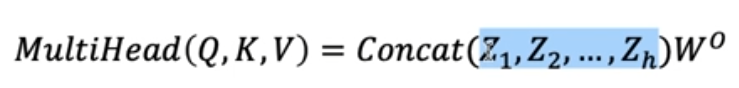

In [41]:
class EncoderLayer(torch.nn.Module) :
    
    def __init__(self, hidden_dim, num_head, dropout_p=0.5) :
        super().__init__()
        
        self.num_head = num_head
        self.hidden_dim = hidden_dim
        
        assert hidden_dim%num_head == 0, "Hidden dim and num of heads are not matched!"
        
        # MultiHeadAttention 정의 방식에 따라 다르게
        self.MHA = MultiHeadAttention()
        # self.MHA = multi_head_attention
        
        # 학습가능 파라미터 설정
        self.W_Q = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_K = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_V = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
        
        self.W_O = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
        
        # Layer Construct
        self.LayerNorm1 = torch.nn.LayerNorm(hidden_dim)
        self.LayerNorm2 = torch.nn.LayerNorm(hidden_dim)
        
        self.Dropout = torch.nn.Dropout(p=dropout_p)
        
        self.Linear1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.Linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        
        self.Activation = torch.nn.ReLU()
        
    def to_multihead(self, vector) :
        num_batch, num_token_length, hidden_dim = vector.shape
        att_dim = hidden_dim // self.num_head
        vector = vector.view(num_batch, num_token_length, self.num_head, att_dim) # (num_batch, num_token_length, num_head, att_dim)
        vector = vector.permute(0,2,1,3) # (num_batch, num_head, num_token_length, att_dim)
        
        return vector
        
    def forward(self, input_Q, input_K, input_V) :
        # input_Q = input_K = input_V : Self Attention, 다르면 Cross Attention
        # input_Q Shape : (batch size, token length, hidden_dim)
        
        Q = self.W_Q(input_Q) # (batch size, token length, hidden_dim)
        K = self.W_K(input_K)
        V = self.W_V(input_V)
        
        num_batch, num_token_length, hidden_dim = Q.shape
        
        """
        MHA 구현을 쪼개서 하기 때문에 병렬적으로 동작한다
        hidden_dim = 64
        num_head = 8
        att_dim = hidden_dim // num_head
        """
        
        # split
        Q = self.to_multihead(Q) # (num_batch, num_head, num_token_length, att_dim)
        K = self.to_multihead(K)
        V = self.to_multihead(V)
        
        # Multi-head Attention
        Z, attention_score = self.MHA(Q,K,V) # (num_batch, num_head, num_token_length, att_dim)
        
        # head dim으로 concat
        Z = Z.permute(0,2,1,3) # (num_batch, num_token_length, num_head, att_dim)
        Z = Z.reshape(num_batch, num_token_length, self.hidden_dim) # self.hidden_dim=num_head*att_dim
        
        Z = self.W_O(Z)
        
        # Add & Norm
        Z = self.LayerNorm1(self.Activation(Z) + input_Q)
        Z1 = self.Dropout(Z)
        
        Z = self.Activation(self.Linear1(Z1))
        Z = self.Dropout(Z)
        Z = self.Activation(self.Linear2(Z))
        Z = self.Dropout(Z)
        
        # Residual Connection
        Z = Z + Z1
        
        # Layer Norm
        Z = self.LayerNorm2(Z)
        
        return Z

In [43]:
device = torch.device("cuda")

num_batch = 16
num_head = 2
hidden_dim = 64
num_token_length = 8

X = torch.Tensor(torch.randn(num_batch, num_token_length, hidden_dim))
print('X.shape :', X.shape)

self_attention_encoder = EncoderLayer(hidden_dim=hidden_dim, num_head=num_head)

Z = self_attention_encoder(input_Q=X, input_K=X, input_V=X)
print("Z.shape :", Z.shape)

X.shape : torch.Size([16, 8, 64])
Z.shape : torch.Size([16, 8, 64])


In [45]:
# Official code와 비교

from torch.nn.modules import TransformerEncoderLayer
official_encoder = TransformerEncoderLayer(d_model=hidden_dim, nhead=num_head, dim_feedforward=hidden_dim)
official_Z = official_encoder(X)
print('Official Z.shape :', official_Z.shape)

Official Z.shape : torch.Size([16, 8, 64])
